In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import ValidationCurveDisplay, validation_curve

## Load data

In [3]:
df = pd.read_excel('PSG_sleep_index_20220928.xlsx')

In [4]:
X = scale(df.iloc[:, 10:19]) # k to s column
y1 = df[['(A6①)寝つきの良さ']]
y2 = df[['(A6③)眠りの深さ']]
y3 = df[['(A6⑤)全体的な睡眠の質']]

feature_names = df.columns[10:19]
len(X)

309

### Binary classification(only for (A6⑤)全体的な睡眠の質)

In [5]:
df_filtered = df[~df['(A6⑤)全体的な睡眠の質'].isin([3])].copy()

# bad is 1, good is 2
df_filtered['(A6⑤)全体的な睡眠の質'] = df_filtered['(A6⑤)全体的な睡眠の質'].apply(lambda x: 2 if x in [1, 2] else 1)

X_filtered = scale(df_filtered.iloc[:, 10:19])  
y3_filtered = df_filtered[['(A6⑤)全体的な睡眠の質']]

len(X_filtered)

201

In [6]:
sleep_quality_counts = df_filtered['(A6⑤)全体的な睡眠の質'].value_counts()
print(sleep_quality_counts)

(A6⑤)全体的な睡眠の質
1    139
2     62
Name: count, dtype: int64


### Oversampling

In [7]:
ros = RandomOverSampler(random_state=0)
X_filtered, y3_filtered = ros.fit_resample(X_filtered, y3_filtered)

len(X_filtered)

278

In [8]:
y3_filtered_series = y3_filtered.iloc[:, 0]
print(y3_filtered_series.value_counts())

(A6⑤)全体的な睡眠の質
1    139
2    139
Name: count, dtype: int64


## SV

In [9]:
from sklearn.svm import SVR
from sklearn.svm import SVC

In [10]:
from sklearn.utils import column_or_1d
y1 = column_or_1d(y1, warn=True)
y2 = column_or_1d(y2, warn=True)
y3 = column_or_1d(y3, warn=True)

/var/folders/26/6_c0j3116r385m4y1ss97ntw0000gp/T/ipykernel_1053/1553019768.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y1 = column_or_1d(y1, warn=True)
/var/folders/26/6_c0j3116r385m4y1ss97ntw0000gp/T/ipykernel_1053/1553019768.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y2 = column_or_1d(y2, warn=True)
/var/folders/26/6_c0j3116r385m4y1ss97ntw0000gp/T/ipykernel_1053/1553019768.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y3 = column_or_1d(y3, warn=True)


In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [12]:
def round_predictions(predictions):
    rounded_predictions = np.where(predictions < 1.5, 1, 
                           np.where(predictions < 2.5, 2, 
                           np.where(predictions < 3.5, 3, 
                           np.where(predictions < 4.5, 4, 5))))
    return rounded_predictions

### regressor

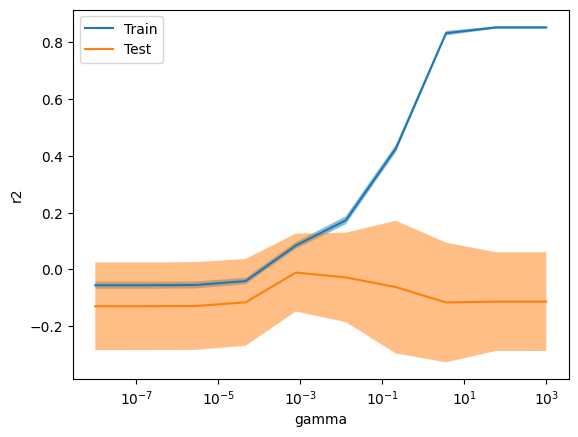

In [13]:
#(A6①)寝つきの良さ
param_range = np.logspace(-8, 3, 10)

kfold = KFold(n_splits=10)

train_scores, test_scores = validation_curve(
    SVR(kernel='rbf', C=1), X, y1, 
    param_name="gamma", param_range=param_range, cv=kfold
)


display = ValidationCurveDisplay(
     param_name="gamma", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="r2"
)


display.plot()
plt.show()

In [14]:
test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

Best gamma value for highest test score: 0.0007742636826811277


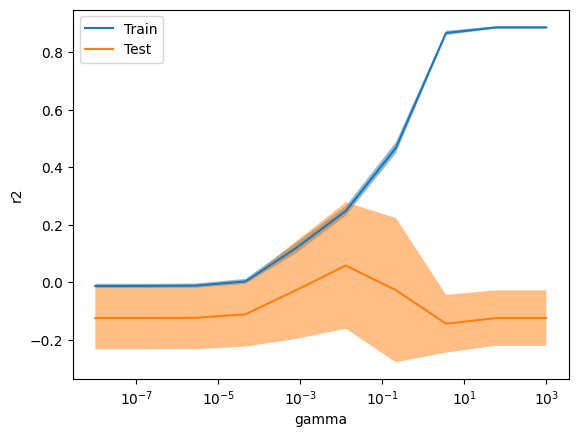

In [15]:
# (A6③)眠りの深さ
param_range = np.logspace(-8, 3, 10)

kfold = KFold(n_splits=10)

train_scores, test_scores = validation_curve(
    SVR(kernel='rbf', C=1), X, y2, 
    param_name="gamma", param_range=param_range, cv=kfold
)


display = ValidationCurveDisplay(
     param_name="gamma", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="r2"
)


display.plot()
plt.show()

In [16]:
test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

Best gamma value for highest test score: 0.012915496650148853


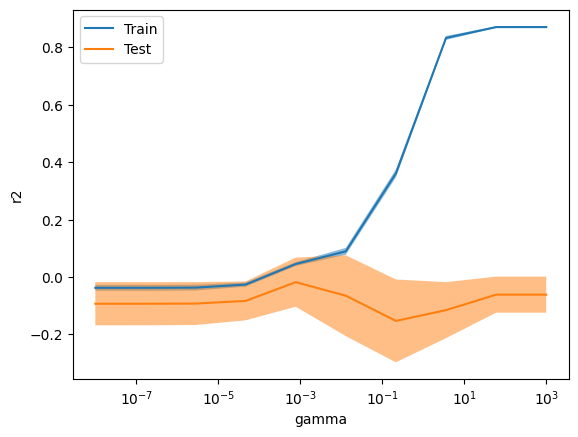

In [17]:
# (A6⑤)全体的な睡眠の質
param_range = np.logspace(-8, 3, 10)

kfold = KFold(n_splits=10)

train_scores, test_scores = validation_curve(
    SVR(kernel='rbf', C=1), X, y3, 
    param_name="gamma", param_range=param_range, cv=kfold
)


display = ValidationCurveDisplay(
     param_name="gamma", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="r2"
)


display.plot()
plt.show()

In [18]:
test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

Best gamma value for highest test score: 0.0007742636826811277


In [19]:
kf = KFold(n_splits=10)

predictions1, true_y1, rounded_predictions1 = [], [], []
predictions2, true_y2, rounded_predictions2 = [], [], []
predictions3, true_y3, rounded_predictions3 = [], [], []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y1_train, y1_test = y1[train_index], y1[test_index]
    y2_train, y2_test = y2[train_index], y2[test_index]
    y3_train, y3_test = y3[train_index], y3[test_index]
    
    # fit
    svr1 = SVR(kernel='rbf', gamma=0.0007742636826811277, C=1).fit(X_train, y1_train)
    svr2 = SVR(kernel='rbf', gamma=0.012915496650148853, C=1).fit(X_train, y2_train)
    svr3 = SVR(kernel='rbf', gamma=0.0007742636826811277, C=1).fit(X_train, y3_train)
    
    # predict
    y1_pred = svr1.predict(X_test)
    y2_pred = svr2.predict(X_test)
    y3_pred = svr3.predict(X_test)

    predictions1.append(y1_pred)
    predictions2.append(y2_pred)
    predictions3.append(y3_pred)
    true_y1.append(y1_test) 
    true_y2.append(y2_test)  
    true_y3.append(y3_test)
    
predictions1 = np.concatenate(predictions1)
predictions2 = np.concatenate(predictions2)
predictions3 = np.concatenate(predictions3)
true_values1 = np.concatenate(true_y1)
true_values2 = np.concatenate(true_y2)
true_values3 = np.concatenate(true_y3)
rounded_predictions1 = round_predictions(predictions1)    
rounded_predictions2 = round_predictions(predictions2) 
rounded_predictions3 = round_predictions(predictions3) 

rmse1 = mean_squared_error(true_values1, rounded_predictions1, squared=False)
rmse2 = mean_squared_error(true_values2, rounded_predictions2, squared=False)
rmse3 = mean_squared_error(true_values3, rounded_predictions3, squared=False)
r2_1 = r2_score(true_values1, rounded_predictions1)
r2_2 = r2_score(true_values2, rounded_predictions2)
r2_3 = r2_score(true_values3, rounded_predictions3)
print("RMSE for rounded (A6①)寝つきの良さ: {:.4f}".format(rmse1))
print("RMSE for rounded (A6③)眠りの深さ: {:.4f}".format(rmse2))
print("RMSE for rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(rmse3))
print("R2 score for rounded (A6①)寝つきの良さ: {:.4f}".format(r2_1))
print("R2 score for rounded (A6③)眠りの深さ: {:.4f}".format(r2_2))
print("R2 score for rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(r2_3))
print("--------------------------------------------------------------")

rmse1 = mean_squared_error(true_values1, predictions1, squared=False)
rmse2 = mean_squared_error(true_values2, predictions2, squared=False)
rmse3 = mean_squared_error(true_values3, predictions3, squared=False)
r2_1 = r2_score(true_values1, predictions1)
r2_2 = r2_score(true_values2, predictions2)
r2_3 = r2_score(true_values3, predictions3)
print("RMSE for no rounded (A6①)寝つきの良さ: {:.4f}".format(rmse1))
print("RMSE for no rounded (A6③)眠りの深さ: {:.4f}".format(rmse2))
print("RMSE for no rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(rmse3))
print("R2 score for no rounded (A6①)寝つきの良さ: {:.4f}".format(r2_1))
print("R2 score for no rounded (A6③)眠りの深さ: {:.4f}".format(r2_2))
print("R2 score for no rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(r2_3))

RMSE for rounded (A6①)寝つきの良さ: 0.9417
RMSE for rounded (A6③)眠りの深さ: 0.9120
RMSE for rounded (A6⑤)全体的な睡眠の質: 0.9502
R2 score for rounded (A6①)寝つきの良さ: -0.0421
R2 score for rounded (A6③)眠りの深さ: 0.0152
R2 score for rounded (A6⑤)全体的な睡眠の質: -0.0566
--------------------------------------------------------------
RMSE for no rounded (A6①)寝つきの良さ: 0.8954
RMSE for no rounded (A6③)眠りの深さ: 0.8442
RMSE for no rounded (A6⑤)全体的な睡眠の質: 0.9138
R2 score for no rounded (A6①)寝つきの良さ: 0.0578
R2 score for no rounded (A6③)眠りの深さ: 0.1560
R2 score for no rounded (A6⑤)全体的な睡眠の質: 0.0230


### Classifier

In [20]:
from sklearn.model_selection import LeaveOneOut

In [21]:
y3_filtered = column_or_1d(y3_filtered, warn=True)

/var/folders/26/6_c0j3116r385m4y1ss97ntw0000gp/T/ipykernel_1053/1037692512.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y3_filtered = column_or_1d(y3_filtered, warn=True)


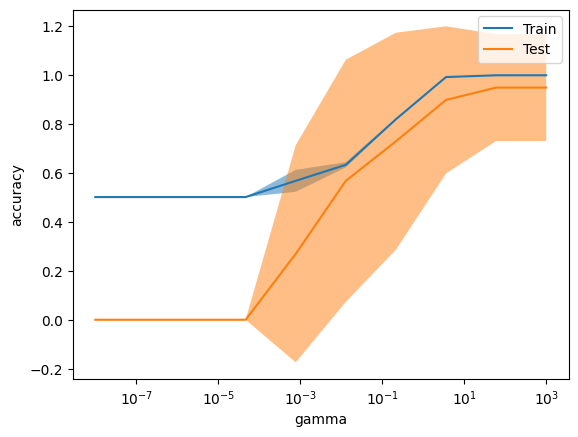

In [26]:
param_range = np.logspace(-8, 3, 10)
loo = LeaveOneOut()

train_scores, test_scores = validation_curve(
    SVC(kernel='rbf', C=1), X_filtered, y3_filtered, 
    param_name="gamma", param_range=param_range, cv=loo
)


display = ValidationCurveDisplay(
     param_name="gamma", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="accuracy"
)


display.plot()
plt.show()

In [27]:
test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

Best gamma value for highest test score: 59.94842503189421


In [28]:
loo = LeaveOneOut()
svc = SVC(kernel='rbf', gamma=59.94842503189421, C=1).fit(X_filtered, y3_filtered)
scores = cross_validate(svc, X_filtered, y3_filtered, cv=loo)

average_test_score = scores['test_score'].mean()

print("Test data Accuracy for (A6⑤)全体的な睡眠の質: {:.4f}".format(average_test_score))

Test data Accuracy for (A6⑤)全体的な睡眠の質: 0.9496


## Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

### Regressor

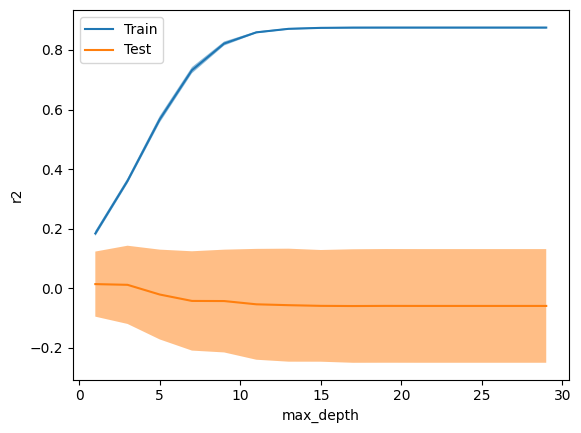

Best gamma value for highest test score: 1


In [30]:
#(A6①)寝つきの良さ
param_range = np.arange(1, 31, 2)

kfold = KFold(n_splits=10)

train_scores, test_scores = validation_curve(
    RandomForestRegressor(n_estimators=200, random_state=0), X, y1, 
    param_name="max_depth", param_range=param_range, cv=kfold
)


display = ValidationCurveDisplay(
     param_name="max_depth", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="r2"
)


display.plot()
plt.show()

test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

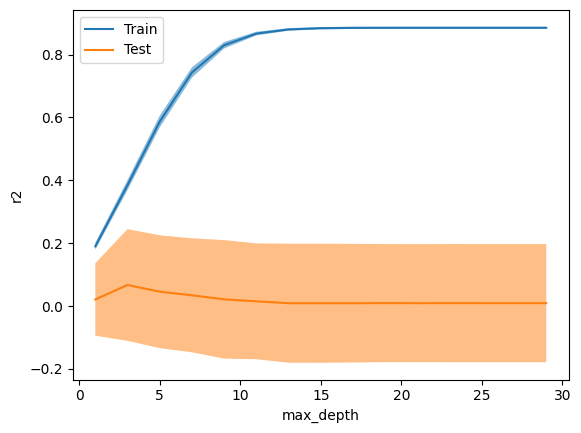

Best gamma value for highest test score: 3


In [31]:
#(A6③)眠りの深さ
param_range = np.arange(1, 31, 2)

kfold = KFold(n_splits=10)

train_scores, test_scores = validation_curve(
    RandomForestRegressor(n_estimators=200, random_state=0), X, y2, 
    param_name="max_depth", param_range=param_range, cv=kfold
)


display = ValidationCurveDisplay(
     param_name="max_depth", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="r2"
)


display.plot()
plt.show()

test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

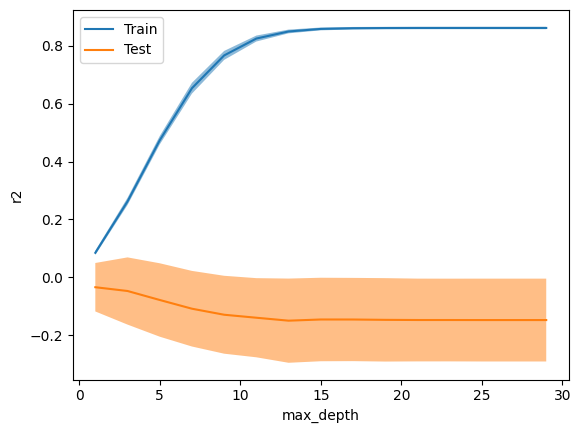

Best gamma value for highest test score: 1


In [32]:
#(A6⑤)全体的な睡眠の質
param_range = np.arange(1, 31, 2)

kfold = KFold(n_splits=10)

train_scores, test_scores = validation_curve(
    RandomForestRegressor(n_estimators=200, random_state=0), X, y3, 
    param_name="max_depth", param_range=param_range, cv=kfold
)


display = ValidationCurveDisplay(
     param_name="max_depth", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="r2"
)


display.plot()
plt.show()

test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

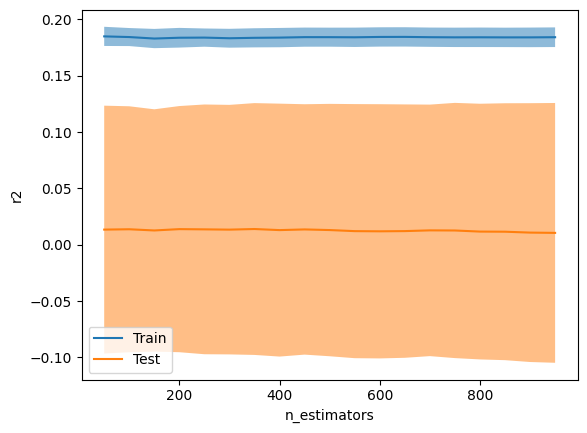

Best gamma value for highest test score: 350


In [33]:
#(A6①)寝つきの良さ
param_range = np.arange(50, 1000, 50)

kfold = KFold(n_splits=10)

train_scores, test_scores = validation_curve(
    RandomForestRegressor(max_depth=1, random_state=0), X, y1, 
    param_name="n_estimators", param_range=param_range, cv=kfold
)


display = ValidationCurveDisplay(
     param_name="n_estimators", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="r2"
)


display.plot()
plt.show()

test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

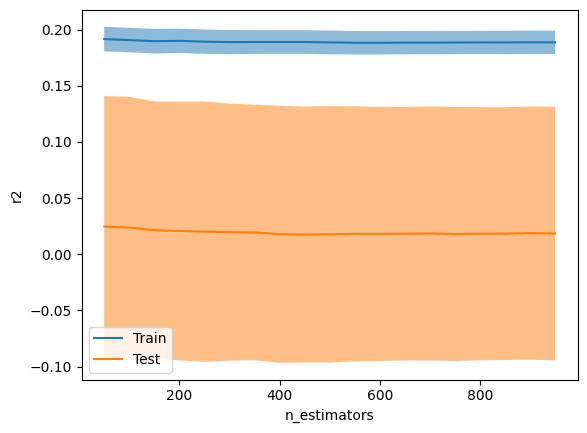

Best gamma value for highest test score: 50


In [35]:
#(A6③)眠りの深さ
param_range = np.arange(50, 1000, 50)

kfold = KFold(n_splits=10)

train_scores, test_scores = validation_curve(
    RandomForestRegressor(max_depth=1, random_state=0), X, y2, 
    param_name="n_estimators", param_range=param_range, cv=kfold
)


display = ValidationCurveDisplay(
     param_name="n_estimators", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="r2"
)


display.plot()
plt.show()

test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

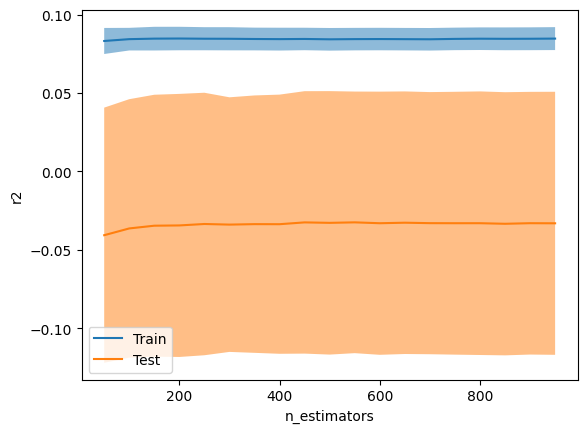

Best gamma value for highest test score: 550


In [34]:
#(A6⑤)全体的な睡眠の質
param_range = np.arange(50, 1000, 50)

kfold = KFold(n_splits=10)

train_scores, test_scores = validation_curve(
    RandomForestRegressor(max_depth=1, random_state=0), X, y3, 
    param_name="n_estimators", param_range=param_range, cv=kfold
)


display = ValidationCurveDisplay(
     param_name="n_estimators", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="r2"
)


display.plot()
plt.show()

test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

In [36]:
kf = KFold(n_splits=10)

predictions1, true_y1, rounded_predictions1 = [], [], []
predictions2, true_y2, rounded_predictions2 = [], [], []
predictions3, true_y3, rounded_predictions3 = [], [], []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y1_train, y1_test = y1[train_index], y1[test_index]
    y2_train, y2_test = y2[train_index], y2[test_index]
    y3_train, y3_test = y3[train_index], y3[test_index]
    
    # fit
    forest1 = RandomForestRegressor(max_depth=1, n_estimators=350, random_state=0).fit(X_train, y1_train)
    forest2 = RandomForestRegressor(max_depth=3, n_estimators=50, random_state=0).fit(X_train, y2_train)
    forest3 = RandomForestRegressor(max_depth=1, n_estimators=550, random_state=0).fit(X_train, y3_train)
    
    # predict
    y1_pred = forest1.predict(X_test)
    y2_pred = forest2.predict(X_test)
    y3_pred = forest3.predict(X_test)

    predictions1.append(y1_pred)
    predictions2.append(y2_pred)
    predictions3.append(y3_pred)
    true_y1.append(y1_test) 
    true_y2.append(y2_test)  
    true_y3.append(y3_test)
    
predictions1 = np.concatenate(predictions1)
predictions2 = np.concatenate(predictions2)
predictions3 = np.concatenate(predictions3)
true_values1 = np.concatenate(true_y1)
true_values2 = np.concatenate(true_y2)
true_values3 = np.concatenate(true_y3)
rounded_predictions1 = round_predictions(predictions1)    
rounded_predictions2 = round_predictions(predictions2) 
rounded_predictions3 = round_predictions(predictions3) 

rmse1 = mean_squared_error(true_values1, rounded_predictions1, squared=False)
rmse2 = mean_squared_error(true_values2, rounded_predictions2, squared=False)
rmse3 = mean_squared_error(true_values3, rounded_predictions3, squared=False)
r2_1 = r2_score(true_values1, rounded_predictions1)
r2_2 = r2_score(true_values2, rounded_predictions2)
r2_3 = r2_score(true_values3, rounded_predictions3)
print("RMSE for rounded (A6①)寝つきの良さ: {:.4f}".format(rmse1))
print("RMSE for rounded (A6③)眠りの深さ: {:.4f}".format(rmse2))
print("RMSE for rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(rmse3))
print("R2 score for rounded (A6①)寝つきの良さ: {:.4f}".format(r2_1))
print("R2 score for rounded (A6③)眠りの深さ: {:.4f}".format(r2_2))
print("R2 score for rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(r2_3))
print("--------------------------------------------------------------")

rmse1 = mean_squared_error(true_values1, predictions1, squared=False)
rmse2 = mean_squared_error(true_values2, predictions2, squared=False)
rmse3 = mean_squared_error(true_values3, predictions3, squared=False)
r2_1 = r2_score(true_values1, predictions1)
r2_2 = r2_score(true_values2, predictions2)
r2_3 = r2_score(true_values3, predictions3)
print("RMSE for no rounded (A6①)寝つきの良さ: {:.4f}".format(rmse1))
print("RMSE for no rounded (A6③)眠りの深さ: {:.4f}".format(rmse2))
print("RMSE for no rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(rmse3))
print("R2 score for no rounded (A6①)寝つきの良さ: {:.4f}".format(r2_1))
print("R2 score for no rounded (A6③)眠りの深さ: {:.4f}".format(r2_2))
print("R2 score for no rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(r2_3))

RMSE for rounded (A6①)寝つきの良さ: 0.9771
RMSE for rounded (A6③)眠りの深さ: 0.9013
RMSE for rounded (A6⑤)全体的な睡眠の質: 0.9870
R2 score for rounded (A6①)寝つきの良さ: -0.1220
R2 score for rounded (A6③)眠りの深さ: 0.0382
R2 score for rounded (A6⑤)全体的な睡眠の質: -0.1399
--------------------------------------------------------------
RMSE for no rounded (A6①)寝つきの良さ: 0.8755
RMSE for no rounded (A6③)眠りの深さ: 0.8486
RMSE for no rounded (A6⑤)全体的な睡眠の質: 0.9189
R2 score for no rounded (A6①)寝つきの良さ: 0.0993
R2 score for no rounded (A6③)眠りの深さ: 0.1474
R2 score for no rounded (A6⑤)全体的な睡眠の質: 0.0120


### Classifier

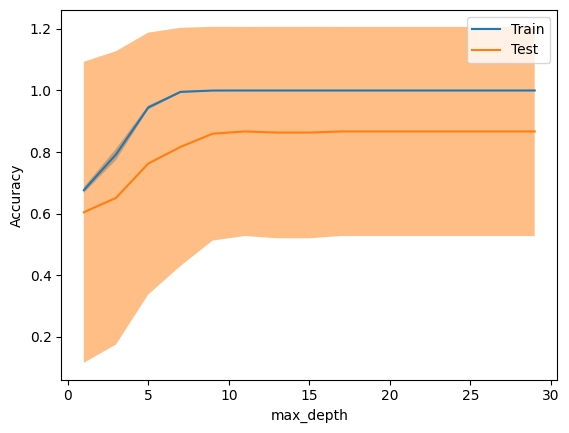

Best gamma value for highest test score: 11


In [46]:
param_range = np.arange(1, 31, 2)

train_scores, test_scores = validation_curve(
    RandomForestClassifier(n_estimators=100,random_state=0), X_filtered, y3_filtered, 
    param_name="max_depth", param_range=param_range, cv=LeaveOneOut()
)


display = ValidationCurveDisplay(
     param_name="max_depth", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="Accuracy"
)


display.plot()
plt.show()

test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

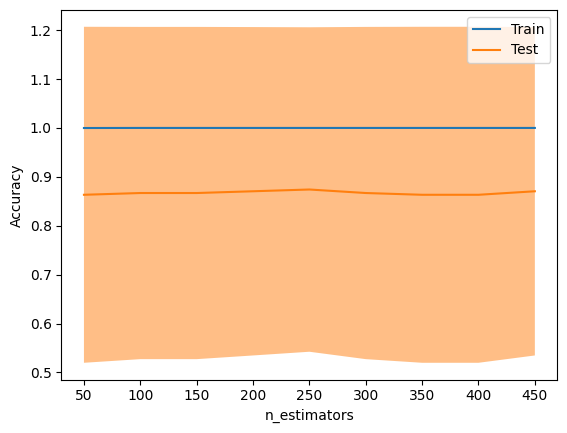

Best gamma value for highest test score: 250


In [52]:
param_range = np.arange(50, 500, 50)


train_scores, test_scores = validation_curve(
    RandomForestClassifier(max_depth=11, random_state=0), X_filtered, y3_filtered, 
    param_name="n_estimators", param_range=param_range, cv=LeaveOneOut()
)


display = ValidationCurveDisplay(
     param_name="n_estimators", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="Accuracy"
)


display.plot()
plt.show()

test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

In [55]:
loo = LeaveOneOut()
forest = RandomForestClassifier(max_depth=11, n_estimators=250,random_state=0).fit(X_filtered, y3_filtered)
scores = cross_validate(forest, X_filtered, y3_filtered, cv=loo, return_train_score=True)

average_test_score = scores['test_score'].mean()

print("Test data Accuracy for (A6⑤)全体的な睡眠の質: {:.4f}".format(average_test_score))

Test data Accuracy for (A6⑤)全体的な睡眠の質: 0.8741


## MLP

In [43]:
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

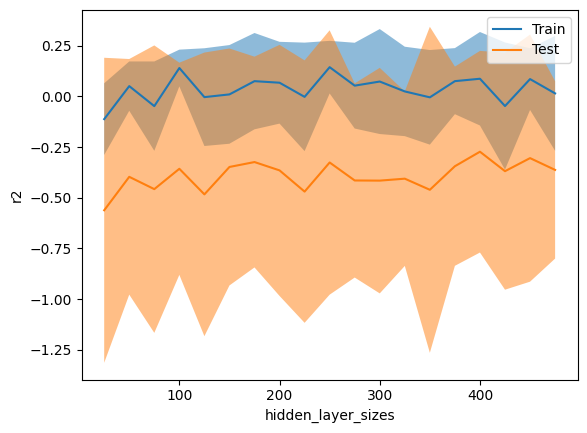

Best gamma value for highest test score: 400


In [48]:
#(A6①)寝つきの良さ
param_range = np.arange(25, 500, 25)

kfold = KFold(n_splits=10)

train_scores, test_scores = validation_curve(
    MLPRegressor(early_stopping=True), X, y1, 
    param_name="hidden_layer_sizes", param_range=param_range, cv=kfold
)


display = ValidationCurveDisplay(
     param_name="hidden_layer_sizes", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="r2"
)


display.plot()
plt.show()

test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

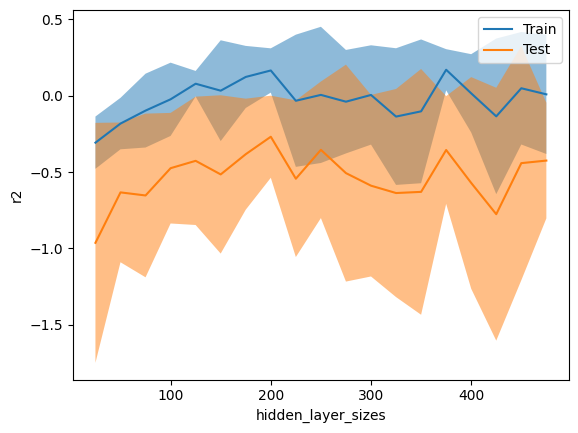

Best gamma value for highest test score: 200


In [49]:
#(A6③)眠りの深さ
param_range = np.arange(25, 500, 25)

kfold = KFold(n_splits=10)

train_scores, test_scores = validation_curve(
    MLPRegressor(early_stopping=True), X, y2, 
    param_name="hidden_layer_sizes", param_range=param_range, cv=kfold
)


display = ValidationCurveDisplay(
     param_name="hidden_layer_sizes", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="r2"
)


display.plot()
plt.show()

test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

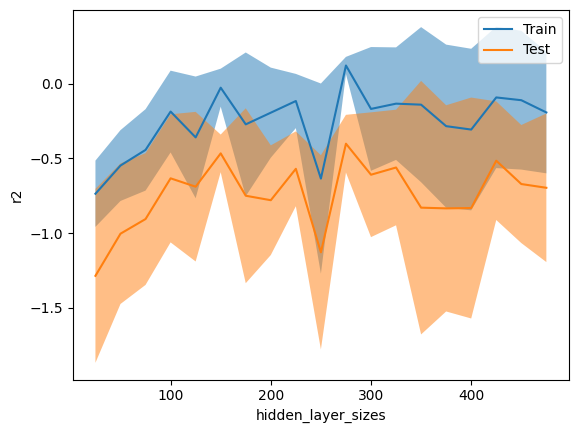

Best gamma value for highest test score: 275


In [50]:
#(A6⑤)全体的な睡眠の質
param_range = np.arange(25, 500, 25)

kfold = KFold(n_splits=10)

train_scores, test_scores = validation_curve(
    MLPRegressor(early_stopping=True), X, y3, 
    param_name="hidden_layer_sizes", param_range=param_range, cv=kfold
)


display = ValidationCurveDisplay(
     param_name="hidden_layer_sizes", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="r2"
)


display.plot()
plt.show()

test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

In [53]:
kf = KFold(n_splits=10)

predictions1, true_y1, rounded_predictions1 = [], [], []
predictions2, true_y2, rounded_predictions2 = [], [], []
predictions3, true_y3, rounded_predictions3 = [], [], []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y1_train, y1_test = y1[train_index], y1[test_index]
    y2_train, y2_test = y2[train_index], y2[test_index]
    y3_train, y3_test = y3[train_index], y3[test_index]
    
    # fit
    mlp1 = MLPRegressor(hidden_layer_sizes=400, early_stopping=True).fit(X_train, y1_train)
    mlp2 = MLPRegressor(hidden_layer_sizes=200, early_stopping=True).fit(X_train, y2_train)
    mlp3 = MLPRegressor(hidden_layer_sizes=275, early_stopping=True).fit(X_train, y3_train)
    
    # predict
    y1_pred = mlp1.predict(X_test)
    y2_pred = mlp2.predict(X_test)
    y3_pred = mlp3.predict(X_test)

    predictions1.append(y1_pred)
    predictions2.append(y2_pred)
    predictions3.append(y3_pred)
    true_y1.append(y1_test) 
    true_y2.append(y2_test)  
    true_y3.append(y3_test)
    
predictions1 = np.concatenate(predictions1)
predictions2 = np.concatenate(predictions2)
predictions3 = np.concatenate(predictions3)
true_values1 = np.concatenate(true_y1)
true_values2 = np.concatenate(true_y2)
true_values3 = np.concatenate(true_y3)
rounded_predictions1 = round_predictions(predictions1)    
rounded_predictions2 = round_predictions(predictions2) 
rounded_predictions3 = round_predictions(predictions3) 

rmse1 = mean_squared_error(true_values1, rounded_predictions1, squared=False)
rmse2 = mean_squared_error(true_values2, rounded_predictions2, squared=False)
rmse3 = mean_squared_error(true_values3, rounded_predictions3, squared=False)
r2_1 = r2_score(true_values1, rounded_predictions1)
r2_2 = r2_score(true_values2, rounded_predictions2)
r2_3 = r2_score(true_values3, rounded_predictions3)
print("RMSE for rounded (A6①)寝つきの良さ: {:.4f}".format(rmse1))
print("RMSE for rounded (A6③)眠りの深さ: {:.4f}".format(rmse2))
print("RMSE for rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(rmse3))
print("R2 score for rounded (A6①)寝つきの良さ: {:.4f}".format(r2_1))
print("R2 score for rounded (A6③)眠りの深さ: {:.4f}".format(r2_2))
print("R2 score for rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(r2_3))
print("--------------------------------------------------------------")

rmse1 = mean_squared_error(true_values1, predictions1, squared=False)
rmse2 = mean_squared_error(true_values2, predictions2, squared=False)
rmse3 = mean_squared_error(true_values3, predictions3, squared=False)
r2_1 = r2_score(true_values1, predictions1)
r2_2 = r2_score(true_values2, predictions2)
r2_3 = r2_score(true_values3, predictions3)
print("RMSE for no rounded (A6①)寝つきの良さ: {:.4f}".format(rmse1))
print("RMSE for no rounded (A6③)眠りの深さ: {:.4f}".format(rmse2))
print("RMSE for no rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(rmse3))
print("R2 score for no rounded (A6①)寝つきの良さ: {:.4f}".format(r2_1))
print("R2 score for no rounded (A6③)眠りの深さ: {:.4f}".format(r2_2))
print("R2 score for no rounded (A6⑤)全体的な睡眠の質: {:.4f}".format(r2_3))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

RMSE for rounded (A6①)寝つきの良さ: 1.0612
RMSE for rounded (A6③)眠りの深さ: 1.0145
RMSE for rounded (A6⑤)全体的な睡眠の質: 1.1603
R2 score for rounded (A6①)寝つきの良さ: -0.3236
R2 score for rounded (A6③)眠りの深さ: -0.2186
R2 score for rounded (A6⑤)全体的な睡眠の質: -0.5754
--------------------------------------------------------------
RMSE for no rounded (A6①)寝つきの良さ: 1.0223
RMSE for no rounded (A6③)眠りの深さ: 0.9783
RMSE for no rounded (A6⑤)全体的な睡眠の質: 1.1433
R2 score for no rounded (A6①)寝つきの良さ: -0.2283
R2 score for no rounded (A6③)眠りの深さ: -0.1334
R2 score for no rounded (A6⑤)全体的な睡眠の質: -0.5296


### classifier

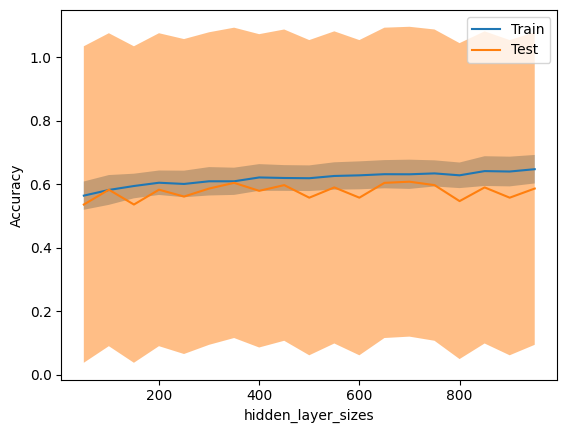

In [51]:
param_range = np.arange(50, 1000, 50)


train_scores, test_scores = validation_curve(
    MLPClassifier(early_stopping=True), X_filtered, y3_filtered, 
    param_name="hidden_layer_sizes", param_range=param_range, cv=LeaveOneOut()
)


display = ValidationCurveDisplay(
     param_name="hidden_layer_sizes", param_range=param_range,
     train_scores=train_scores, test_scores=test_scores, score_name="Accuracy"
)


display.plot()
plt.show()

In [54]:
test_scores_mean = np.mean(test_scores, axis=1)

best_index = np.argmax(test_scores_mean)

best_gamma = param_range[best_index]
print("Best gamma value for highest test score:", best_gamma)

Best gamma value for highest test score: 250


In [56]:
loo = LeaveOneOut()
mlp = MLPClassifier(hidden_layer_sizes=250 ,early_stopping=True).fit(X_filtered, y3_filtered)
scores = cross_validate(mlp, X_filtered, y3_filtered, cv=loo, return_train_score=True)

average_test_score = scores['test_score'].mean()

print("Test data Accuracy for (A6⑤)全体的な睡眠の質: {:.4f}".format(average_test_score))

Test data Accuracy for (A6⑤)全体的な睡眠の質: 0.6151
